### 당뇨병의 유뮤와 신체검사 데이터
1. 시각화를 포함하여 탐색적 자료 분석 (EDA)
2. 이상치를 식별하고 처리 
3. 클래스의 불균형 존재하기 때문에 이 불균형을 어떻게 처리해야 하는가
4. Linear regression, SVM, xgboost를 사용하여 모델링 비교 -> 속도, 예측 두 부분은 확인
5. 속도 개선을 위한 차원 축소 후 예측 성능과 속도를 비교

### EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv("./data/diabetes_for_test.csv")
df1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


- 데이터의 컬럼
    - Pregnancies : 임신 횟수
    - Glucose : 포도당
    - BllodPressure : 혈압
    - SkinThickness : 피부 두께
    - Insulin : 2시간 혈청 인슐린
    - BMI : BMI
    - DiabetesPedigreeFunction : 당뇨병 혈통기능
    - Age : 나이
    - Outcome : 당뇨병의 유무

In [3]:
## 당뇨의 유무에 따른 독립변수 분포 확인
diabetes = df1.groupby('Outcome').mean()
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,36.934000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


Text(0.5, 0.98, 'EDA')

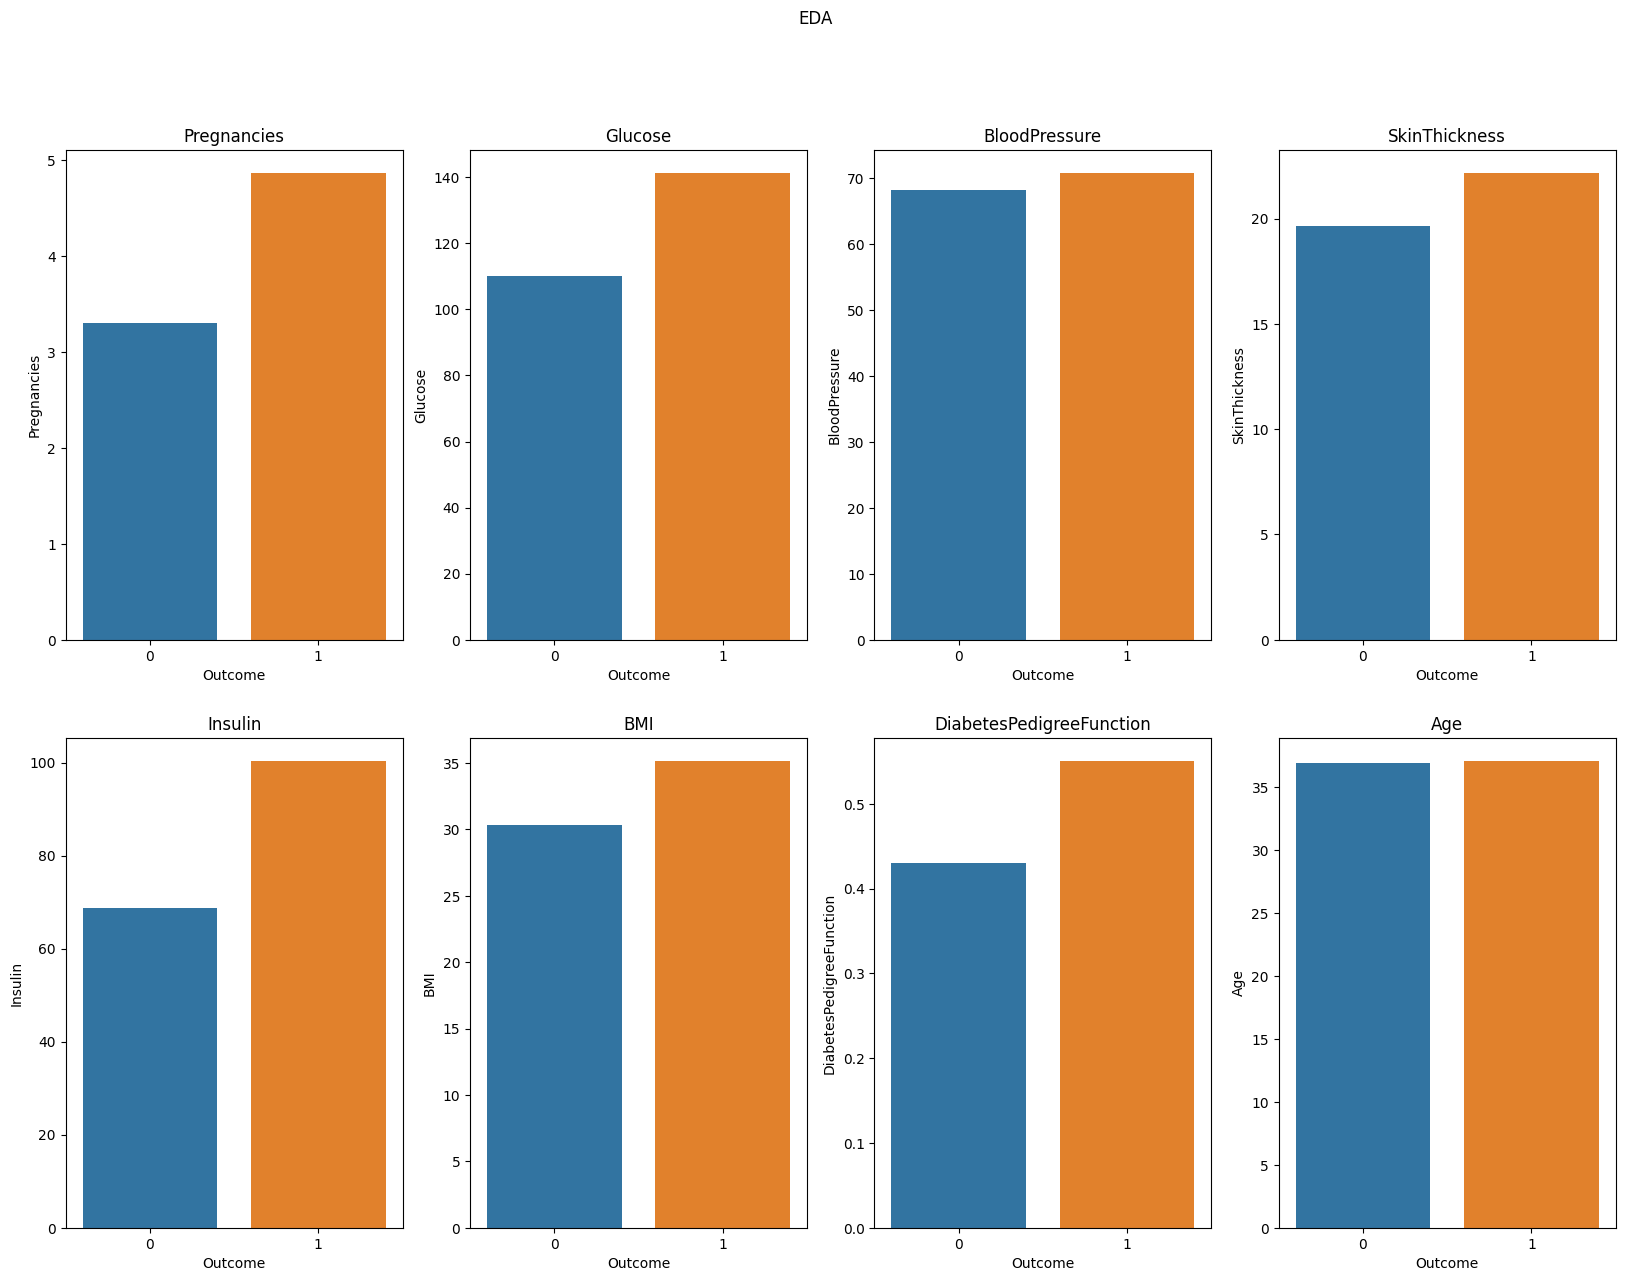

In [4]:
## 분포를 시각화
fig, axes = plt.subplots(2, 4, figsize=(20,14))

for i in range(4):
    sns.barplot(data = diabetes, x = diabetes.index, y = diabetes.iloc[:, i], ax = axes[0][i])
    axes[0][i].set_title(diabetes.columns[i])
for i in range(4):
    sns.barplot(data=diabetes, x = diabetes.index, y = diabetes.iloc[:, i+4], ax = axes[1][i])
    axes[1][i].set_title(diabetes.columns[i+4])

plt.suptitle('EDA')


### EDA 해석
- 당뇨병이 있는 사람은 없는 사람보다 임신 횟수의 평균 수치가 높다
- 당뇨병이 있는 사람은 없는 사람보다 포도당의 평균 수치가 높다. 
- 당뇨병이 있는 사람은 없는 사람보다 인슐린의 평균 수치가 높다. 
- 당뇨병이 있는 사람은 없는 사람보다 BMI의 평균 수치가 높다

<AxesSubplot: >

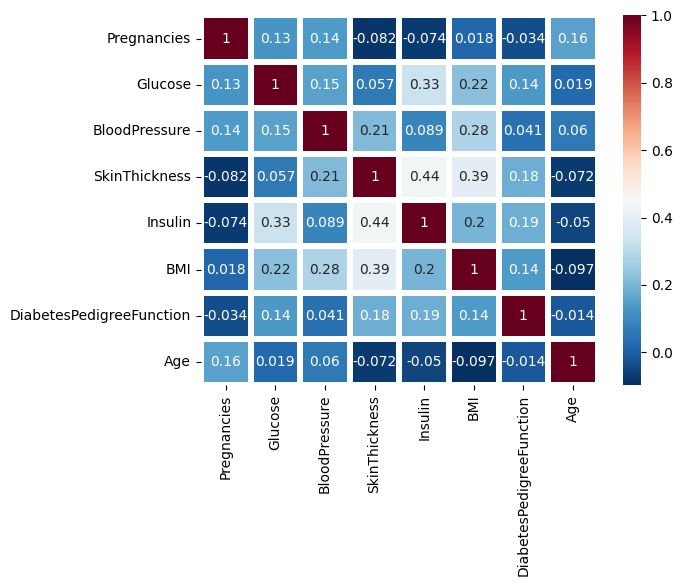

In [5]:
## Outcome을 제외한 변수들 간의 상관성 확인
df_cor = df1.drop(columns=['Outcome']).corr(method='pearson')

sns.heatmap(
    df_cor, 
    xticklabels= df_cor.columns, 
    yticklabels= df_cor.columns, 
    cmap = 'RdBu_r', 
    annot = True, 
    linewidth = 3
)

- 0.9 이상의 상관관계를 가지는 변수는 존재하지 않는다
- 모든 변수를 사용하여 모델링해도 될것으로 판단

### 이상치 식별 및 처리

In [6]:
df1.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,36.980469,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,61.404453,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,999.000000,1.000000


- 각 변수들의 결측치는 없는것으로 확인
- 이상치를 판단하기 위해서는 mean, min, max 값을 확인
- 평균과 min, 평균과 max 값이 std에 비해 한참 차이가 난다면 이상치가 존재할 가능성이 높다
- 이상치를 판단하기 위해서는 boxplot으로 시각화하여 보는것이 정확

In [7]:
x = df1.drop(columns=['Outcome'])
df_v1 = pd.melt(x, var_name='col', value_name='value')
df_v1

,col,value
0,Pregnancies,6.0
1,Pregnancies,1.0
2,Pregnancies,8.0
3,Pregnancies,1.0
4,Pregnancies,0.0
...,...,...
6139,Age,63.0
6140,Age,27.0
6141,Age,30.0
6142,Age,47.0


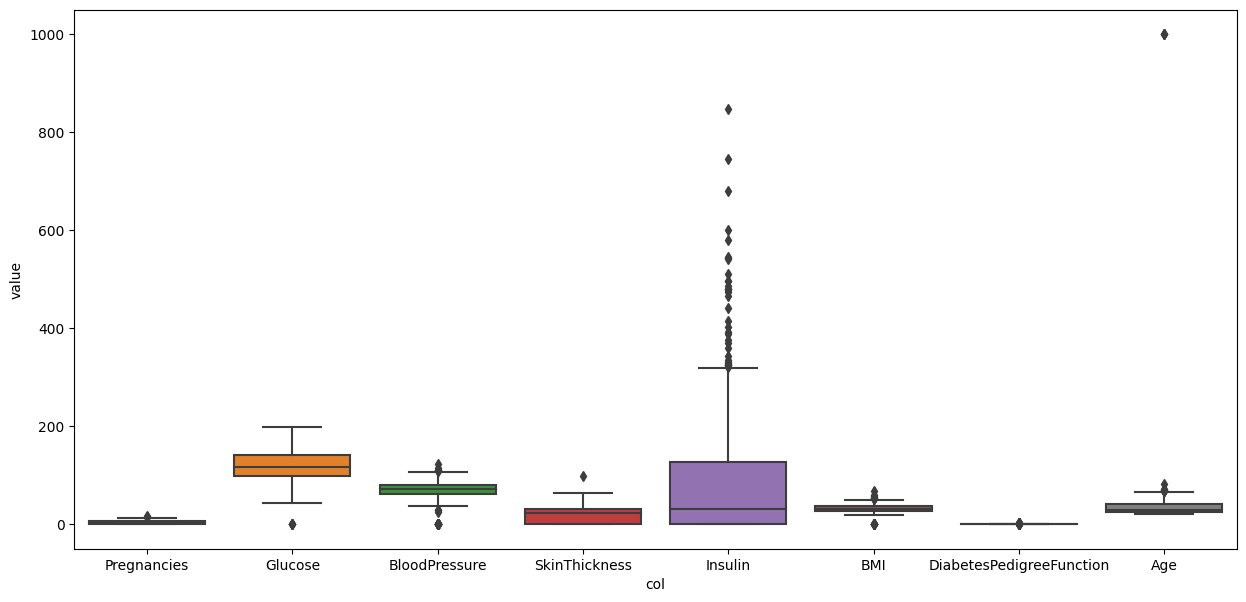

In [8]:
## boxplot 생성
plt.figure(figsize=(15,7))
sns.boxplot(x = 'col', y = 'value', data = df_v1)
plt.xticks(range(8), x.columns)
plt.show()

- Age의 경우 중앙값과 멀리 떨어진 이상치가 존재
- Insulin의 경우 이상치가 존재하지만, 이상치들이 연속적으로 이어져 있기 때문에 이상치를 가진 사람이 있을수 있다는 가정하에 Age의 이상치만 처리

In [9]:
## Age 컬럼에 눈에 띄는 이상치(999)가 있기 때문에 Age의 중앙값으로 대체
print('Age의 중앙값 : ', df1.Age.median())

Age의 중앙값 :  29.0


<AxesSubplot: >

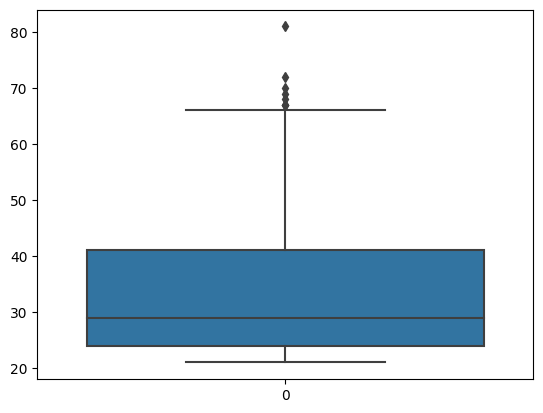

In [10]:
outlier_index = df1[df1['Age'] > 150].index
df1.loc[outlier_index, 'Age'] = df1.Age.median()

sns.boxplot(df1['Age'])

In [11]:
## Glucose, Bloodpressure 컬럼에 0이 존재하지 않아야된다고 판단
## 이러한 수치들을 이상치 판단하여 중앙값으로 대체
outlier_index = df1[df1['Glucose'] == 0].index
df1.loc[outlier_index, 'Glucose'] = df1.Glucose.median()
outlier_index = df1[df1['BloodPressure'] == 0].index
df1.loc[outlier_index, 'BloodPressure'] = df1.BloodPressure.median()

df1.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,20.536458,79.799479,31.992578,0.471876,33.191406,0.348958
std,3.369578,30.438286,12.096642,15.952218,115.244002,7.884160,0.331329,11.683509,0.476951
min,0.000000,44.000000,24.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- 최소값과 최대값 차이가 많이 나는 컬럼들이 존재
- 선형모델 사용시 scale을 적용할 필요

### 데이터의 불균형 처리
- 현재의 데이터가 총 768개로 적은 데이터가 존재
- 언더샘플링을 하는경우에는 적은 데이터가 더 적어지므로 오버피팅이 일어날 위험이 크다. 
- 오버샘플링을 선택

### 모델링과 오버샘플링

In [12]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sklearn.svm as svm

log = LogisticRegression()
xgb = XGBClassifier(random_state=0)
svm_clf = svm.SVC(kernel='linear')

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import time
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
x = df1.drop(columns=['Outcome'])
y = df1[['Outcome']]

## 5개의 경우의 수로 분할하여 검증
kfold = KFold()

def model_result(model):
    pred_li = []

    for train_index, test_index in kfold.split(x):
        x_train, x_test = x.iloc[train_index, :], x.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index, :], y.iloc[test_index, :]

        ## 오버샘플링
        x_train_resample, y_train_resample = smote.fit_resample(x_train, y_train)

        start = time.time()
        model.fit(x_train_resample, y_train_resample)
        end = time.time()

        pred = model.predict(x_test)
        pred_li.append(accuracy_score(pred, y_test['Outcome']))
    
    ## 마지막 데이터 학습 속도 
    print(f"{end - start:.5f} sec")
    ## 5개의 train 데이터에 대한 정확도의 평균 값
    print(np.mean(pred_li))


In [14]:
model_result(log)

0.01209 sec
0.7487904252610134


In [15]:
model_result(xgb)

0.06477 sec
0.7474492827434004


In [16]:
model_result(svm_clf)

2.21119 sec
0.7605126899244546


- 오버샘플링은 SMOTE로 활용
- 속도적인 면에서 보면 Logistic이 가장 우수
- 예측 성능 면에서는 SVM이 가장 우수

### 속도 개선을 위한 차원 축소 후 모델링 실행 예측 성능과 속도 비교

In [17]:
## 차원 축소 방법 PCA
## PCA를 사용하는 경우 데이터 스케일에 따라 주 성분이 설명 가능한 분산량이 달라질 수 있기 때문에
## 데이터 스케일링 작업을 해주어야 한다

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

smote = SMOTE(random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=2023)

scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train)

pca = PCA(n_components=8)
x_train_pca = pca.fit(x_train_s)

print(pca.explained_variance_ratio_)

[0.25339789 0.23528713 0.11816303 0.11215281 0.10228709 0.07505843
 0.05346631 0.0501873 ]


In [18]:
print(pca.explained_variance_ratio_[:5].sum())

0.8212879584273779


- 독립 변수까지 차원 축소 시켜 적절한 주 성분의 개수를 찾아보면 8개의 독립 변수 대신 5개의 주 성분까지 사용하면 전체 데이터에 82%를 설명할수 있다.

In [19]:
def pca_model_result(model):
    pred_li = []

    for train_index, test_index in kfold.split(x):
        x_train, x_test = x.iloc[train_index, :], x.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index, :], y.iloc[test_index, :]

        x_train_resample, y_train_resample = smote.fit_resample(x_train, y_train)

        scaler = StandardScaler()
        x_train_res_s = scaler.fit_transform(x_train_resample)
        x_test_s = scaler.transform(x_test)

        pca = PCA(n_components=5)
        x_train_pca = pca.fit_transform(x_train_res_s)
        x_test_pca = pca.transform(x_test_s)

        start = time.time()
        model.fit(x_train_pca, y_train_resample)
        end = time.time()

        pred = model.predict(x_test_pca)
        pred_li.append(accuracy_score(pred, y_test['Outcome']))

    print(f"{end - start:.5f} sec")
    print(np.mean(pred_li))

In [20]:
model_result(log)

0.01152 sec
0.7487904252610134


In [21]:
pca_model_result(log)

0.00139 sec
0.7279093455564045


In [22]:
model_result(xgb)

0.06152 sec
0.7474492827434004


In [23]:
pca_model_result(xgb)

0.06046 sec
0.7031491384432561


In [24]:
model_result(svm_clf)

2.14618 sec
0.7605126899244546


In [25]:
pca_model_result(svm_clf)

0.01181 sec
0.7253034547152193


- 예측 성능은 차원 축소를 하기 전이 더 우수
- 속도 면에서는 차원 축소를 하고 나서 더 우수
- 향후 데이터의 크기가 늘어난다면 성능 및 속도 측면에서 더 유의미한 차이가 클 것이라 보인다. 